# Applied Data Science - Exploring Neighborhoods of Toronto to Open an Indian Restaurant
***

#### Install Required Python Libraries for the Project

In [1]:
!pip install wikipedia
!pip install geopy
!pip install folium
!conda install -c districtdatalabs yellowbrick

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11685 sha256=24f82acac0731532c6116e627bd88539672c96420c3079b2f183fc4d7b5c8f3c
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia
     |████████████████████████████████| 93 kB 3.9 MB/s  eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pytest-runner-5.2          |             py_0          13 KB
    yellowbrick-1.1            |           py37_0         276 KB  districtdatalabs
    ------------------------------------------------------------
                                           Total:         289 KB

The following NEW packages will be INSTALLED:

  pytest-runner

#### Load Required Python Libraries for the Project

In [2]:
# Load the required libraries

import pandas as pd
import numpy as np
import wikipedia as wp
import io
import requests
import json
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


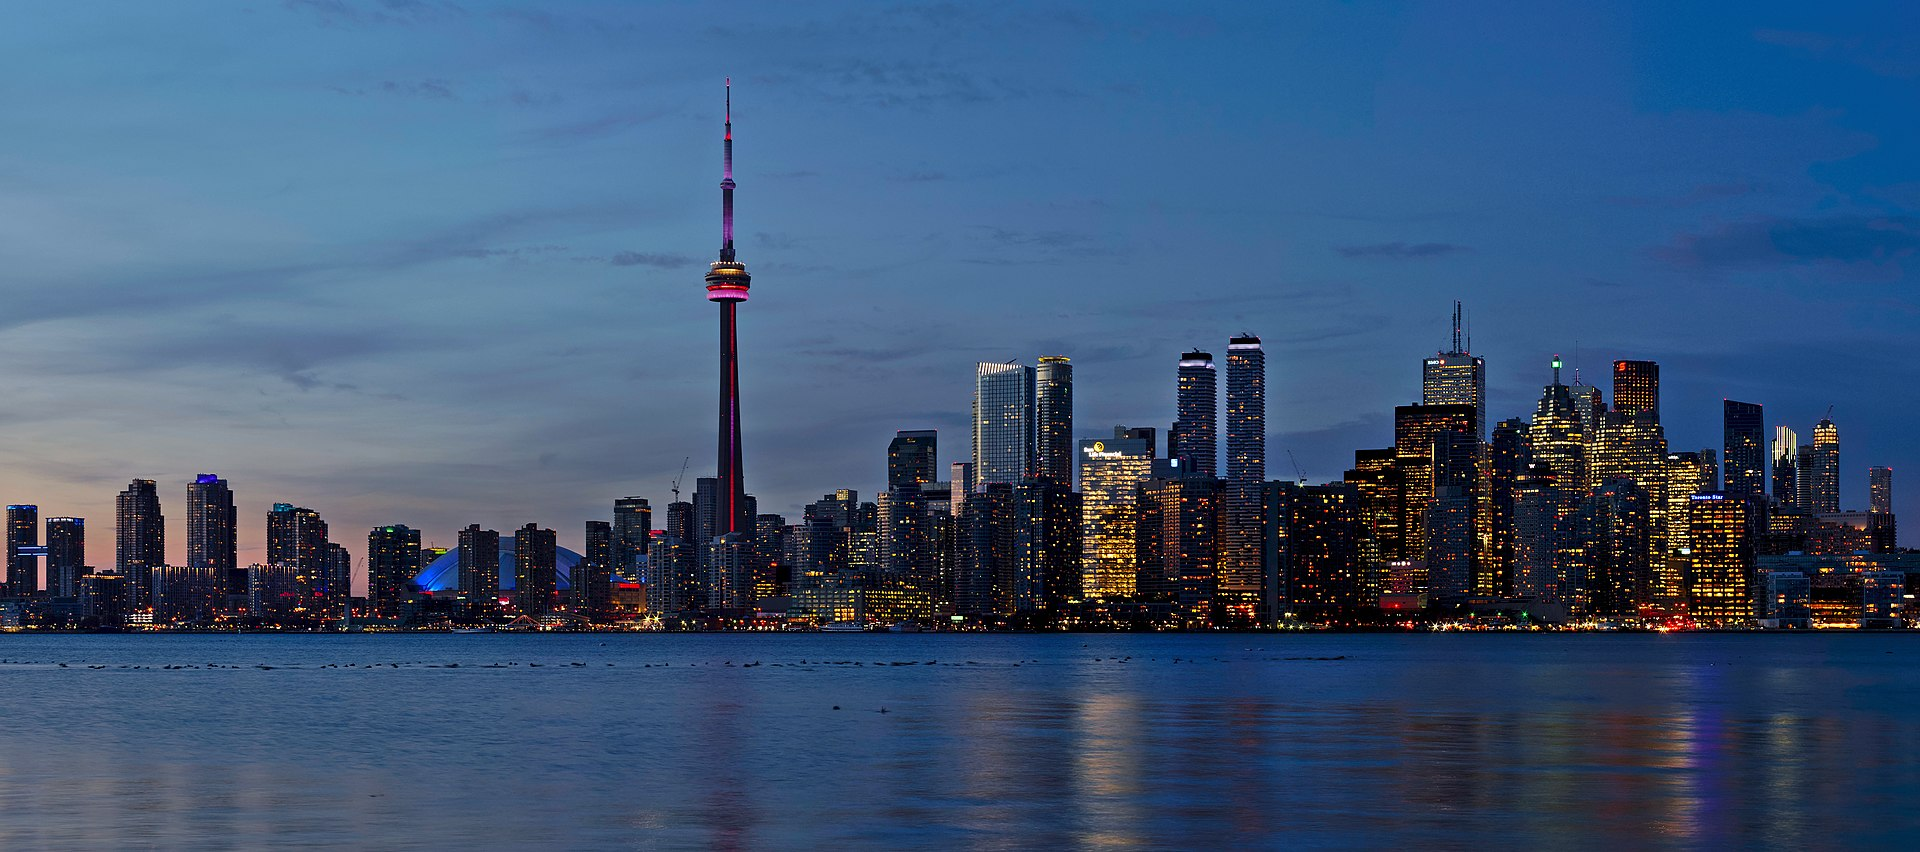Toronto Cityscape (Image Source Wikipedia)

## 1. Introduction

## 1. Introduction:

> ### 1.1 - Background
>
> As a part of the Applied Data Science Capstone Project, we have to work on data science toolsets on a real-life problem on real world datasets to get an experience of what data scientists do. Objectives of this assignment is to source data available in the internet and use Foursquare Location Data to compare different neighborhoods of Toronto and figure out which neighborhood is the most suitable for starting a new restaurant business. In this project, we'll progress in a step by step manner from problem description, data preparation to final analysis and finally will provide a recommendation that can be leveraged by the stakeholders to make business decisions.
>
> ### 1.2 - Business Problem
>
> Toronto is the capital city of the Canadian province of Ontario. With a recorded population of 2,731,571 in 2016, it is the most populous city in Canada and the fourth most populous city in North America. Diversity of the city is reflected in the ethnic neighborhoods such as Chinatown, Corso Italia, Greektown, Kensington Market, Koreatown, Little India, Little Italy, Little Jamaica, Little Portugal & Roncesvalles. Toronto is one of the most immigrant friendly cities in North America. With more than half of the entire Indian Canadian population residing here, Toronto is one of the best cities to start an Indian Restaurant Business.
>
> In this project we will go through a step by step process to take an informed decision on whether it's a good idea to open an Indian Restaurant in Toronto. We will analyze all the neighborhoods in Toronto to identify the most profitable area for the restaurant to operate. Since we already know that Toronto shelters a huge number of Indians than any other city in Canada, it will be a good idea to start an Indian Restaurant here, however we need to establish whether it is a profitable idea or not. If so, in which locality we can open it to maximize returns to the investors.
>
> ### 1.3 - Target Audience
>
> * Investors who want to invest in Indian Restaurant Business in the city of Toronto, Canada. This analysis will provide the investors with a list of suitable localities for consideration to start a restaurant targeting the Indian food lovers.
> * Food lovers can use this analysis to find neighborhoods with availability of Indian Food.
> * Data Scientists who wish to analyze the neighborhoods of Toronto using Exploratory Data Analysis and other Statistical & Machine Learning techniques can use this analysis as a guidance.

## 2. Data:

> ### 2.1 - Data Sources
>
> * Neighborhoods Data - "List_of_postal_codes_of_Canada:_M" [Wikipedia Page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)  
> This Wikipedia Page contains Postal Code, Borough & Neighborhood Names in Toronto
> * Geographical Coordinates - [Geospatial CSV](https://cocl.us/Geospatial_data)  
> This CSV File contains Geographical coordinates of the Neighborhoods
> * Demographics Data - “Demographics of Toronto” [Wikipedia Page](https://en.m.wikipedia.org/wiki/Demographics_of_Toronto)  
> This Wikipedia Page contains information on the distribution of population by ethnicity
> * Venues Details - [Foursquare’s Explore API](https://developer.foursquare.com/)  
> Foursquare API can be used to retrieve details for each of the venues in Toronto
>
> ### 2.2 - Data Cleaning
>
> Neighborhood data scrapped from Wikipedia has three features; Postal Code, Borough and Neighborhood.  
> The records with no assigned Borough (< 1%) were excluded from the analysis.  
> It was observed that more than one Neighborhoods can exist in the same Postal Code Area. These Neighborhoods were combined into one row separated by comma to remove duplicate Postal Codes in the dataset.  
> For Boroughs with unassigned Neighborhoods, the Neighborhood name has been considered same as the Borough to avoid missing values in the dataset.  
> Demographics Data extracted from Wikipedia was filtered to keep only the data points related to Indian Population.  
> For this analysis Venue Details from Foursquare’s Explored API was filtered to retain only the top 100 venues within 1 KM radius of each neighborhood.  
> The following four features from the Venue Details were retained for further analysis:  
> * Name - Name of the Venue
> * Category - Category Type as defined by the API
> * Latitude - Latitude value of the Venue
> * Longitude - Longitude value of the Venue

> #### a) Scrape and Clean Neighborhood data from Wikipedia

In [3]:
# Scrape the Neighborhood data from Wikipedia

html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df_PostalCode = pd.read_html(html, header = 0)[0]

In [4]:
# Only process the records that have an assigned borough. Ignore records where borough is Not assigned

df_PostalCode = df_PostalCode[df_PostalCode.Borough != 'Not assigned']
df_PostalCode = df_PostalCode.rename(columns = {'Postal Code': 'Postalcode'})
df_PostalCode = df_PostalCode.rename(columns = {'Neighbourhood': 'Neighborhood'})

# If a record has an assigned Borough but unassigned Neighborhood, then the Neighborhood name will be the same as the Borough

for index, row in df_PostalCode.iterrows():
    if row['Neighborhood'] == 'Not assigned':
        row['Neighborhood'] = row['Borough']

# If a Postal Code Area has more than one Neighborhoods then combine the Neighborhoods into one row separated by comma        

df_PostalCode = df_PostalCode.groupby(['Borough', 'Postalcode'])['Neighborhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()

In [5]:
df_PostalCode.head(10)

,Borough,Postalcode,Neighborhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"
5,Central Toronto,M4V,"Summerhill West, Rathnelly, South Hill, Forest..."
6,Central Toronto,M5N,Roselawn
7,Central Toronto,M5P,"Forest Hill North & West, Forest Hill Road Park"
8,Central Toronto,M5R,"The Annex, North Midtown, Yorkville"
9,Downtown Toronto,M4W,Rosedale


> #### b) Add Geographical Coordinates to the Neighborhood data

In [6]:
# Extract the Latitude & Longitude values from the Geospatial CSV file

url = "https://cocl.us/Geospatial_data"
Geospatial = requests.get(url).text
df_Geospatial = pd.read_csv(io.StringIO(Geospatial))

# Rename the Columns to align with the existing dataframe  

df_Geospatial = df_Geospatial.rename(columns = {'Postal Code': 'Postalcode'})

In [7]:
# Merge both the dataframes into one using Postal Codes as key

df_Toronto = pd.merge(df_PostalCode, df_Geospatial, on = 'Postalcode')

In [8]:
df_Toronto.head(10)

,Borough,Postalcode,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160
5,Central Toronto,M4V,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049
6,Central Toronto,M5N,Roselawn,43.711695,-79.416936
7,Central Toronto,M5P,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307
8,Central Toronto,M5R,"The Annex, North Midtown, Yorkville",43.672710,-79.405678
9,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529


In [9]:
print('The city of Toronto has {} Boroughs and {} Neighborhoods'.format(len(df_Toronto['Borough'].unique()), df_Toronto.shape[0]))

The city of Toronto has 10 Boroughs and 103 Neighborhoods


> #### c) Scrape distribution of Population from Wikipedia

In [10]:
# Population distribution in Toronto from Wikipedia

html = wp.page("Demographics of Toronto").html().encode("UTF-8")

# TORONTO & EAST YORK - Population distribution by Ethnicity

df_Pop_TEY = pd.read_html(html, header = 0)[12]
df_Pop_TEY = df_Pop_TEY.rename(columns = {'%':'Ethnic Origin 1 in %', '%.1':'Ethnic Origin 2 in %', '%.2':'Ethnic Origin 3 in %',
                                          '%.3':'Ethnic Origin 4 in %', '%.4':'Ethnic Origin 5 in %', '%.5':'Ethnic Origin 6 in %', 
                                          '%.6':'Ethnic Origin 7 in %', '%.7':'Ethnic Origin 8 in %', '%.8':'Ethnic Origin 9 in %'})

# NORTH YORK - Population distribution by Ethnicity

df_Pop_NY = pd.read_html(html, header = 0)[13]
df_Pop_NY = df_Pop_NY.rename(columns={'%':'Ethnic Origin 1 in %', '%.1':'Ethnic Origin 2 in %', '%.2':'Ethnic Origin 3 in %', '%.3':'Ethnic Origin 4 in %', 
                                      '%.4':'Ethnic Origin 5 in %', '%.5':'Ethnic Origin 6 in %', '%.6':'Ethnic Origin 7 in %', '%.7':'Ethnic Origin 8 in %'})

# SCARBOROUGH - Population distribution by Ethnicity

df_Pop_Scar = pd.read_html(html, header = 0)[14]
df_Pop_Scar = df_Pop_Scar.rename(columns={'%':'Ethnic Origin 1 in %', '%.1':'Ethnic Origin 2 in %', '%.2':'Ethnic Origin 3 in %', '%.3':'Ethnic Origin 4 in %', 
                                          '%.4':'Ethnic Origin 5 in %', '%.5':'Ethnic Origin 6 in %', '%.6':'Ethnic Origin 7 in %', '%.7':'Ethnic Origin 8 in %'})

# ETOBICOKE & YORK - Population distribution by Ethnicity

df_Pop_ETY = pd.read_html(html, header = 0)[15]
df_Pop_ETY = df_Pop_ETY.rename(columns={'%':'Ethnic Origin 1 in %', '%.1':'Ethnic Origin 2 in %', '%.2':'Ethnic Origin 3 in %', '%.3':'Ethnic Origin 4 in %', 
                                        '%.4':'Ethnic Origin 5 in %', '%.5':'Ethnic Origin 6 in %', '%.6':'Ethnic Origin 7 in %', '%.7':'Ethnic Origin 8 in %'})

In [11]:
# Merge all the population table with the ethnic percentage by neighborhood

df_Pop = df_Pop_TEY.append(df_Pop_NY).reset_index()
df_Pop.drop('index', axis = 1, inplace = True)
df_Pop = df_Pop.append(df_Pop_Scar).reset_index()
df_Pop.drop('index', axis = 1, inplace = True)
df_Pop = df_Pop.append(df_Pop_ETY).reset_index()
df_Pop.drop('index', axis = 1, inplace = True)

In [12]:
df_Pop.head(10)

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Spadina-Fort York,114315,English,16.4,Chinese,16.0,Irish,14.6,Canadian,14.0,Scottish,13.2,French,7.70,German,7.6,NaN,NaN,NaN,NaN
1,Beaches-East York,108435,English,24.2,Irish,19.9,Canadian,19.7,Scottish,18.9,French,8.7,German,8.40,NaN,NaN,NaN,NaN,NaN,NaN
2,Davenport,107395,Portuguese,22.7,English,13.6,Canadian,12.8,Irish,11.5,Italian,11.1,Scottish,11.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Parkdale-High Park,106445,English,22.3,Irish,20.0,Scottish,18.7,Canadian,16.1,German,9.8,French,8.88,Polish,8.5,NaN,NaN,NaN,NaN
4,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,Canadian,18.4,Chinese,13.8,French,8.86,German,8.8,Greek,7.3,NaN,NaN
5,Toronto-St. Paul's,104940,English,18.5,Canadian,16.1,Irish,15.2,Scottish,14.8,Polish,10.3,German,7.90,Russian,7.7,Italian,7.3,French,7.2
6,University-Rosedale,100520,English,20.6,Irish,16.6,Scottish,16.3,Canadian,15.2,Chinese,14.7,German,8.70,French,7.7,Italian,7.4,NaN,NaN
7,Toronto Centre,99590,English,15.7,Canadian,13.7,Irish,13.4,Scottish,12.6,Chinese,12.5,French,7.20,NaN,NaN,NaN,NaN,NaN,NaN
8,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.50,Irish,9.2,Russian,8.4,NaN,NaN


> #### d) Get location data using Foursquare API

In [13]:
# Use geopy library to get the latitude and longitude values of Toronto, Canada

address = 'Toronto, Canada'

geolocator = Nominatim(user_agent = "Toronto_Explorer")
location = geolocator.geocode(address)
latitude_tor = location.latitude
longitude_tor = location.longitude
print('The geograpical coordinates of Toronto, Canada : Latitude {}, Longitude {}'.format(latitude_tor, longitude_tor))

The geograpical coordinates of Toronto, Canada : Latitude 43.6534817, Longitude -79.3839347


In [ ]:
# Define Foursquare Credentials and Version

USER_ID = '' # your Foursquare ID
USER_SECRET = '' # your Foursquare Secret
VERSION = '20201111' # Foursquare API version

print('Foursquare API Credentials : User ID {} and Secret {}'.format(USER_ID,USER_SECRET))

In [15]:
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(USER_ID, USER_SECRET, latitude_tor, longitude_tor, VERSION, radius)
results = requests.get(url).json()

In [16]:
#Function to get the category

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Using the get_category_type function, we clean up the json and turn it into a pandas dataframe

In [17]:
venues = results['response']['groups'][0]['items']

nearby_venues = pd.json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [18]:
nearby_venues.head(10)

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Indigo,Bookstore,43.653515,-79.380696
3,CF Toronto Eaton Centre,Shopping Mall,43.654447,-79.380952
4,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684
5,UNIQLO ユニクロ,Clothing Store,43.655910,-79.380641
6,Four Seasons Centre for the Performing Arts,Concert Hall,43.650592,-79.385806
7,Poke Guys,Poke Place,43.654895,-79.385052
8,LUSH,Cosmetics Shop,43.653557,-79.380400
9,Textile Museum of Canada,Art Museum,43.654396,-79.386500


Now we can explore the nearby venues !

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(USER_ID, USER_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [20]:
LIMIT = 100
toronto_venues = getNearbyVenues(names = df_Toronto['Neighborhood'], latitudes = df_Toronto['Latitude'], longitudes = df_Toronto['Longitude'])

In [21]:
toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park
5,Davisville North,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop
6,Davisville North,43.712751,-79.390197,Winners,43.713236,-79.393873,Department Store
7,Davisville North,43.712751,-79.390197,Best Western Roehampton Hotel & Suites,43.708878,-79.390880,Hotel
8,Davisville North,43.712751,-79.390197,Subway,43.708474,-79.390674,Sandwich Place
9,Davisville North,43.712751,-79.390197,900 Mount Pleasant - Residents Gym,43.711671,-79.391767,Gym / Fitness Center


We will do one hot encoding for getting dummies of venue category. So that we will calculate mean of all venue groupby there neighbourhoods.

In [22]:
toronto_one_hot = pd.get_dummies(toronto_venues[['Venue Category']], prefix = "", prefix_sep = "")
toronto_one_hot['Neighborhood'] = toronto_venues['Neighborhood']

fixed_columns = [toronto_one_hot.columns[-1]] + list(toronto_one_hot.columns[:-1])
toronto_one_hot = toronto_one_hot[fixed_columns]
toronto_grouped = toronto_one_hot.groupby('Neighborhood').mean().reset_index()

In [23]:
toronto_grouped.head(10)

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,Berczy Park,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,0.0,0.0
6,"Birch Cliff, Cliffside West",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,"Business reply mail Processing Centre, South C...",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0,0.0,0.058824,0.058824,0.058824,0.117647,0.117647,0.058824,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
print('There are {} uniques categories of venue, in which Indian Restaurant is one'.format(len(toronto_venues['Venue Category'].unique())))

There are 277 uniques categories of venue, in which Indian Restaurant is one


## 3. Exploratory Data Analysis

### 3.1 Folium Library and Toronto Map

I am using Folium Python Library to draw an interactive map of Toronto using the coordinates dataset

In [25]:
# create map of Toronto using latitude and longitude values

map_toronto = folium.Map(location = [latitude_tor, longitude_tor], zoom_start = 11)

# add markers to map

for lat, lng, borough, neighborhood in zip(df_Toronto['Latitude'], df_Toronto['Longitude'], df_Toronto['Borough'], df_Toronto['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_toronto)  
    
map_toronto

### 3.2 Relationship between Neighborhood and Indian Restaurants

In [26]:
df_Indian_Restaurant = toronto_grouped[['Neighborhood', 'Indian Restaurant']]

In [27]:
df_Indian_Restaurant.head(10)

,Neighborhood,Indian Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.045455
5,Berczy Park,0.000000
6,"Birch Cliff, Cliffside West",0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000
8,"Business reply mail Processing Centre, South C...",0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000


In [28]:
df_Indian_Restaurant = pd.merge(df_Toronto, df_Indian_Restaurant, on = 'Neighborhood')

In [29]:
df_Indian_Restaurant.head(10)

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Indian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.000000
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,0.000000
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.029412
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,0.000000
5,Central Toronto,M4V,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,0.000000
6,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.000000
7,Central Toronto,M5P,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307,0.000000
8,Central Toronto,M5R,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,0.052632
9,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.000000


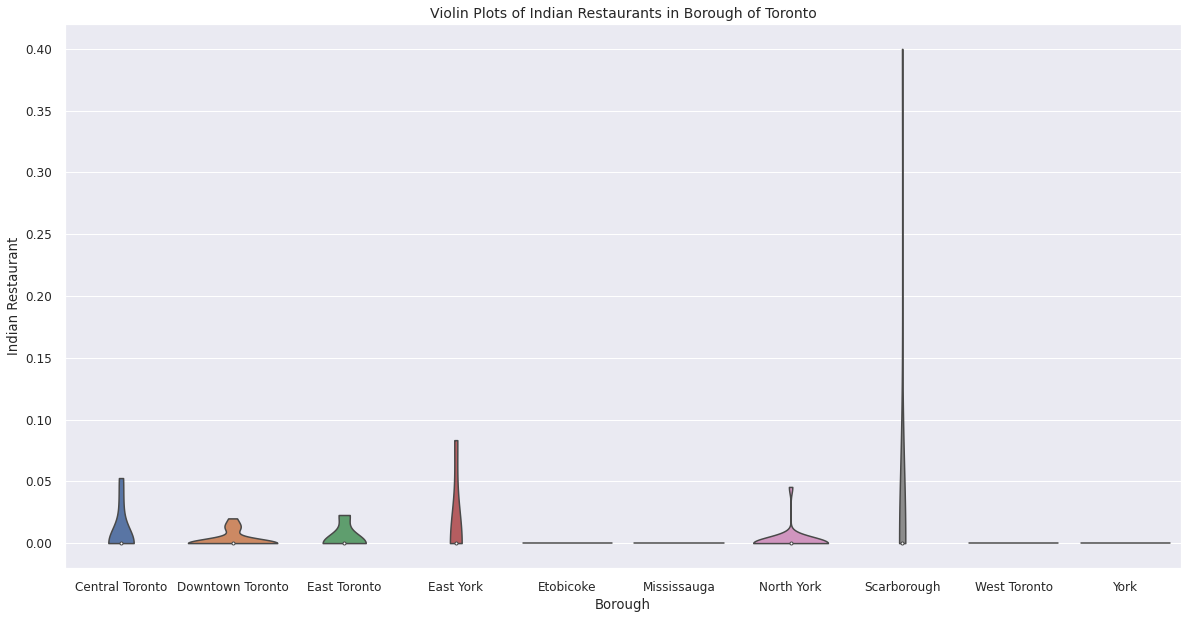

In [30]:
# Create a Categorical Plot

fig = plt.figure(figsize = (20, 10))

sns.set(font_scale = 1.1)
sns.violinplot(y = "Indian Restaurant", x = "Borough", data = df_Indian_Restaurant, cut = 0);
plt.title('Violin Plots of Indian Restaurants in Borough of Toronto', fontsize = 14)
plt.show()

This plot helps in identifying the boroughs with densely populated Indian restaurants.  

Visualize the Neighborhoods with Indian Restaurants

In [31]:
%matplotlib inline

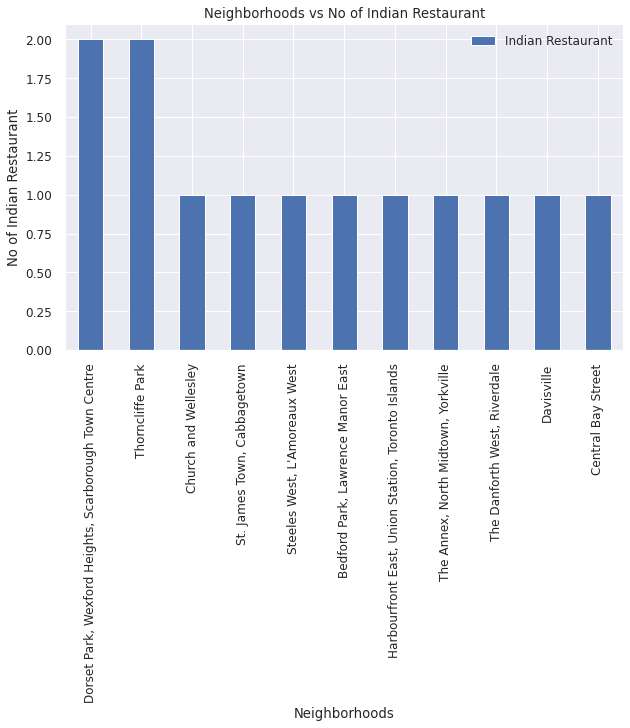

In [32]:
graph = pd.DataFrame(toronto_one_hot.groupby('Neighborhood')['Indian Restaurant'].sum())
graph = graph.sort_values(by ='Indian Restaurant', ascending = False)
graph = graph[graph['Indian Restaurant'] != 0]
graph.plot(kind = 'bar', figsize = (10, 6))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Indian Restaurant")
plt.title("Neighborhoods vs No of Indian Restaurant")
plt.show()

### 3.3 Relationship between neighborhood and Indian Population

In [33]:
# Filtering the riding with Indian ethnic crowd
Ind = df_Pop.loc[(df_Pop['Ethnic Origin #1'] == 'East Indian')|(df_Pop['Ethnic Origin #2'] == 'East Indian')|(df_Pop['Ethnic Origin #3'] == 'East Indian')|
                 (df_Pop['Ethnic Origin #4'] == 'East Indian')|(df_Pop['Ethnic Origin #5'] == 'East Indian')|(df_Pop['Ethnic Origin #6'] == 'East Indian')|
                 (df_Pop['Ethnic Origin #7'] == 'East Indian')|(df_Pop['Ethnic Origin #8'] == 'East Indian')|(df_Pop['Ethnic Origin #9'] == 'East Indian')]
df_Pop_Ind = pd.DataFrame(Ind).reset_index()
df_Pop_Ind.drop('index', axis = 1, inplace = True)

In [34]:
# Retaining only Indian Ethnic Percentage & Neighbourhood Name

col_list = df_Pop_Ind.columns.to_list()
df_Indian_Population = pd.DataFrame()

# Removing Riding & Population from the Column names list

del col_list[0]
del col_list[0]

for i in range(0, df_Pop_Ind.shape[0]):
    for j in col_list:
        if df_Pop_Ind.at[i, j] == 'East Indian':
            k = col_list.index(j) + 1
            perc_col = col_list[k]
            df_Indian_Population = df_Indian_Population.append({'Riding':df_Pop_Ind.at[i,'Riding'], 'Population':df_Pop_Ind.at[i,'Population'], 'Ethnicity':df_Pop_Ind.at[i, j], 'Percentage':df_Pop_Ind.at[i, perc_col]}, ignore_index = True)

In [35]:
df_Indian_Population['Indian Population'] = (df_Indian_Population['Percentage'] * df_Indian_Population['Population'])/100
df_Indian_Population.drop(columns = {'Percentage','Population','Ethnicity'}, axis = 1, inplace = True)
df_Indian_Population.drop_duplicates(keep = 'first', inplace = True)

In [36]:
df_Indian_Population.head(10)

,Riding,Indian Population
0,Don Valley North,7961.380
1,Humber River-Black Creek,9910.700
2,Don Valley East,9876.020
3,Scarborough Centre,13474.900
4,Scarborough Southwest,8880.190
5,Scarborough-Agincourt,7712.650
6,Scarborough-Rouge Park,16941.315
7,Scarborough-Guildwood,18200.700
8,Scarborough North,11517.980
9,Etobicoke North,25965.120


Visualize the Neighborhoods with Indian Population

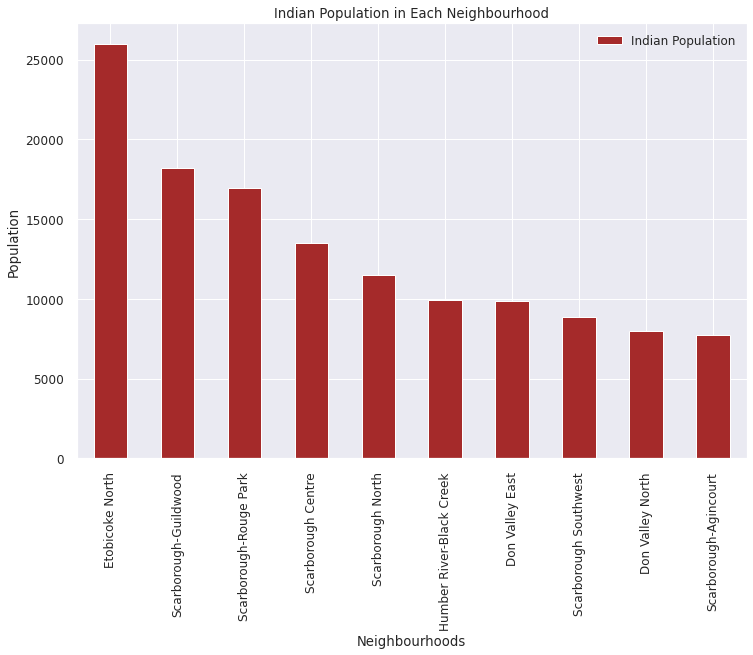

In [37]:
bar_graph = df_Indian_Population.sort_values(by = 'Indian Population', ascending = False)
bar_graph.plot(kind = 'bar', x = 'Riding', y = 'Indian Population', figsize = (12, 8), color = 'brown')
plt.title("Indian Population in Each Neighbourhood")
plt.xlabel("Neighbourhoods")
plt.ylabel("Population")
plt.show()

This analysis & visualization of the relationship between neighborhoods & indian population present in those neighborhoods helps us in identifying the highly populated indian neighborhoods. Once we identify those neighborhoods it helps us in deciding where to place the new Indian restaurant. Indian restaurant placed in an densely populated Indian neighborhood is more likely to get more Indian customers than a restaurant placed in a neighborhood with less or no Indian population. Thus this analysis helps in the determining the success of the new Indian restaurant. 

### 3.4 Relationship between Indian Poplation and Indian Restaurant

First get the list of neighborhoods present in the riding using the Wikipedia geography section for each riding. Altering the riding names to match the wikipedia page so we can retrieve the neighborhoods present in those ridings.

In [38]:
# Altering the list to match the wikipedia page so we can retrieve the neighborhoods present in those Ridings

riding_list = df_Indian_Population['Riding'].to_list()
riding_list[riding_list.index('Scarborough Centre')] = 'Scarborough Centre (electoral district)'
riding_list[riding_list.index('Scarborough North')] = 'Scarborough North (electoral district)'

In [39]:
# Scraping Wikipedia page to get the neighborhoods of each Ridings

Riding_neighborhood_df = pd.DataFrame()

for item in riding_list:
    section = wp.WikipediaPage(item).section('Geography')
    start = section.index('neighbourhoods of') + 17
    stop = section.index('.',start)
    Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding':item, 'Neighborhood':section[start:stop]}, ignore_index = True)

Riding_neighborhood_df = Riding_neighborhood_df[['Riding','Neighborhood']]
for index, row in Riding_neighborhood_df.iterrows():
    if row['Riding'] == 'Scarborough Centre (electoral district)':
        row['Riding'] = 'Scarborough Centre'
    if row['Riding'] == 'Scarborough North (electoral district)':
        row['Riding'] = 'Scarborough North'

In [40]:
Riding_neighborhood_df.head(10)

,Riding,Neighborhood
0,Don Valley North,"Henry Farm, Bayview Village, Bayview Woods-St..."
1,Humber River-Black Creek,"Humber Summit, Humbermede, Humberlea, York Un..."
2,Don Valley East,"Flemingdon Park, Don Mills, Graydon Hall, Par..."
3,Scarborough Centre,Scarborough City Centre (west of McCowan Road...
4,Scarborough Southwest,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
5,Scarborough-Agincourt,"Steeles, L'Amoreaux, Tam O'Shanter-Sullivan, ..."
6,Scarborough-Rouge Park,"Morningside Heights, Rouge, Port Union, West ..."
7,Scarborough-Guildwood,"Guildwood, West Hill (west of Morningside Ave..."
8,Scarborough North,"Agincourt (east of Midland Avenue), Milliken ..."
9,Etobicoke North,"The Elms, Humberwood, Kingsview Village, This..."


In [41]:
# Merge Indian population dataframe with the Neighborhood dataframe

Neigh_pop = pd.merge(df_Indian_Population, Riding_neighborhood_df, on = 'Riding')

Neigh_pop.drop(columns = ['Riding'],inplace = True)

In [42]:
Neigh_pop.head(10)

,Indian Population,Neighborhood
0,7961.380,"Henry Farm, Bayview Village, Bayview Woods-St..."
1,9910.700,"Humber Summit, Humbermede, Humberlea, York Un..."
2,9876.020,"Flemingdon Park, Don Mills, Graydon Hall, Par..."
3,13474.900,Scarborough City Centre (west of McCowan Road...
4,8880.190,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
5,7712.650,"Steeles, L'Amoreaux, Tam O'Shanter-Sullivan, ..."
6,16941.315,"Morningside Heights, Rouge, Port Union, West ..."
7,18200.700,"Guildwood, West Hill (west of Morningside Ave..."
8,11517.980,"Agincourt (east of Midland Avenue), Milliken ..."
9,25965.120,"The Elms, Humberwood, Kingsview Village, This..."


In [43]:
# Split the Indian Population dataset to show one Neighborhood per record

Neigh_pop['split_neighborhoods'] = Neigh_pop['Neighborhood'].str.split(',') 
Neigh_pop.drop(columns = ['Neighborhood'], inplace = True, axis = 1)
Neigh_pop = Neigh_pop.split_neighborhoods.apply(pd.Series).merge(Neigh_pop, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                     .melt(id_vars = ['Indian Population'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()
Neigh_pop = Neigh_pop.reset_index(drop = True)

In [44]:
Neigh_pop.head(10)

,Indian Population,Neighborhood
0,7961.380,Henry Farm
1,9910.700,Humber Summit
2,9876.020,Flemingdon Park
3,13474.900,Scarborough City Centre (west of McCowan Road)
4,8880.190,Birch Cliff
5,7712.650,Steeles
6,16941.315,Morningside Heights
7,18200.700,Guildwood
8,11517.980,Agincourt (east of Midland Avenue)
9,25965.120,The Elms


In [45]:
# Split the Indian Restaurant dataset to show one Neighborhood per record

Neigh_rest = df_Indian_Restaurant.loc[:, ['Neighborhood', 'Indian Restaurant']]
Neigh_rest['split_neighborhoods'] = Neigh_rest['Neighborhood'].str.split(',')
Neigh_rest.drop(columns = ['Neighborhood'], inplace = True, axis = 1)
Neigh_rest = Neigh_rest.split_neighborhoods.apply(pd.Series).merge(Neigh_rest, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Indian Restaurant'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()
Neigh_rest = Neigh_rest.reset_index(drop = True)

In [46]:
Neigh_rest.head(10)

,Indian Restaurant,Neighborhood
0,0.000000,Lawrence Park
1,0.000000,Davisville North
2,0.000000,North Toronto West
3,0.029412,Davisville
4,0.000000,Moore Park
5,0.000000,Summerhill West
6,0.000000,Roselawn
7,0.000000,Forest Hill North & West
8,0.052632,The Annex
9,0.000000,Rosedale


In [47]:
# Merge the Indian Population and Restaurant datasets

Neigh_pop_rest = pd.merge(Neigh_pop, Neigh_rest, on = 'Neighborhood')

In [48]:
Neigh_pop_rest

,Indian Population,Neighborhood,Indian Restaurant
0,7961.380,Henry Farm,0.0
1,8880.190,Oakridge,0.0
2,16941.315,Rouge,0.0
3,16941.315,Port Union,0.0
4,18200.700,Morningside,0.0
5,25965.120,Thistletown,0.0
6,8880.190,Clairlea,0.0
7,16941.315,Highland Creek,0.0
8,13474.900,Maryvale,0.0


After performing data cleaning & analysis we found that there no prominent relationship between Indian Population & Indian Restaurants

This marks the end of the EDA step in this project. Next we will look into the predictive modeling part. In the predictive modelling part we will use Clustering techniques since this is analysis of unlabelled data. K-Means clustering will be used to perform the analysis.

## 4. Predictive Modeling

### 4.1 Clustering Neighborhoods of Toronto

First step in K-means clustering is to identify best K value or the number of clusters in a given dataset. To do so we are going to use the elbow method on the Toronto dataset with Indian Restaurant Percentage

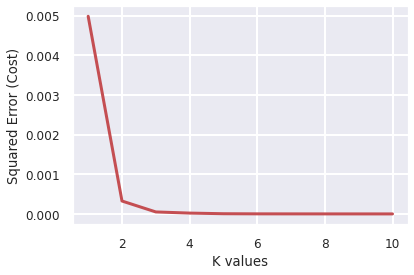

In [49]:
Neigh_rest_clustering = Neigh_rest.drop('Neighborhood', 1)

error_cost = []

for i in range(1, 11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(Neigh_rest_clustering)
    except ValueError:
        print("error on line", i)
    
    # Calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

# Plot the K values aganist the squared error cost
plt.plot(range(1, 11), error_cost, color = 'r', linewidth = '3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color = 'white', linestyle = '-', linewidth = 2)
plt.show()

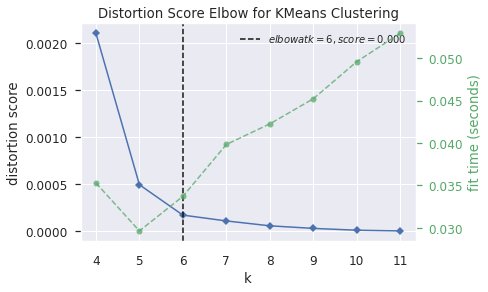

In [50]:
# Instantiate the clustering model and visualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k = (4, 12))

visualizer.fit(Neigh_rest_clustering) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

After analysing the dataset using elbow method using Distortion Score & Squared Error for each K value, looks like K = 6 is the best value.

#### Clustering the Toronto Neighborhood Using K-Means with K = 6

In [51]:
kclusters = 6

Neigh_rest_clustering = Neigh_rest.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(Neigh_rest_clustering)

kmeans.labels_

array([0, 0, 0, 5, 0, 0, 0, 0, 2, 0, 5, 4, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [52]:
Neigh_rest.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = df_Toronto

# Merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood

toronto_merged = toronto_merged.join(Neigh_rest.set_index('Neighborhood'), on = 'Neighborhood')
toronto_merged.dropna(subset = ["Cluster Labels"], axis = 0, inplace = True)
toronto_merged.reset_index(drop = True, inplace = True)
toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head(10)

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.000000
2,Central Toronto,M4S,Davisville,43.704324,-79.388790,5.0,0.029412
3,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.000000
4,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.0,0.000000
5,Downtown Toronto,M4Y,Church and Wellesley,43.665860,-79.383160,4.0,0.013333
6,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,5.0,0.020000
7,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,0.0,0.000000
8,Downtown Toronto,M5E,Berczy Park,43.644771,-79.373306,0.0,0.000000
9,Downtown Toronto,M5G,Central Bay Street,43.657952,-79.387383,4.0,0.014706


In [53]:
toronto_merged.head(10)

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.000000
2,Central Toronto,M4S,Davisville,43.704324,-79.388790,5.0,0.029412
3,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.000000
4,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.0,0.000000
5,Downtown Toronto,M4Y,Church and Wellesley,43.665860,-79.383160,4.0,0.013333
6,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,5.0,0.020000
7,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,0.0,0.000000
8,Downtown Toronto,M5E,Berczy Park,43.644771,-79.373306,0.0,0.000000
9,Downtown Toronto,M5G,Central Bay Street,43.657952,-79.387383,4.0,0.014706


Let us see the clusters visually on the map with the help of Folium.

In [54]:
map_clusters = folium.Map(location = [latitude_tor, longitude_tor], zoom_start = 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)

map_clusters

### 4.2 Examing the Clusters

We have total of 6 clusters (0,1,2,3,4,5). Let us examine one after the other.

Cluster 0 contains all the neighborhoods which has least number of Indian Restaurants. It is displayed in Red Circles in the map.

In [55]:
# Cluster 0

toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.0
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.0
3,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.0
4,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.0,0.0
7,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,0.0,0.0
8,Downtown Toronto,M5E,Berczy Park,43.644771,-79.373306,0.0,0.0
10,Downtown Toronto,M5W,Stn A PO Boxes,43.646435,-79.374846,0.0,0.0
11,Downtown Toronto,M6G,Christie,43.669542,-79.422564,0.0,0.0
12,East Toronto,M4E,The Beaches,43.676357,-79.293031,0.0,0.0
13,East Toronto,M4M,Studio District,43.659526,-79.340923,0.0,0.0


Cluster 1 has no rows meaning no data points or neighborhood was near to this centroid.

In [56]:
# Cluster 1

toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant


Cluster 2 has no rows meaning no data points or neighborhood was near to this centroid.

In [57]:
# Cluster 2

toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant


Cluster 3 contains all the neighborhoods which have medium density of Indian Restaurants. These are shown in Blue Circles in the map.

In [58]:
# Cluster 3

toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
16,East York,M4H,Thorncliffe Park,43.705369,-79.349372,3.0,0.083333


Cluster 4 contains all the Neighborhoods which are medium to densely populated with Indian Restaurants. These are displayed by Green Circles in the map.

In [59]:
# Cluster 4

toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
5,Downtown Toronto,M4Y,Church and Wellesley,43.665860,-79.383160,4.0,0.013333
9,Downtown Toronto,M5G,Central Bay Street,43.657952,-79.387383,4.0,0.014706


Cluster 5 contains all the Neighborhoods which are densely populated with Indian Restaurants. These are displayed by Orange Circles in the map.

In [60]:
# Cluster 5

toronto_merged.loc[toronto_merged['Cluster Labels'] == 5]

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
2,Central Toronto,M4S,Davisville,43.704324,-79.388790,5.0,0.029412
6,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,5.0,0.020000


## 5. Results and Discussion

> ### 5.1 Results
>
> We have reached the end of the analysis and will document all the findings from the above clustering & visualization of the datasets. In this project, as the business problem started with identifying a good Neighborhood to open a new Indian Restaurant, we looked into all the Neighborhoods in Toronto, analyzed the Indian Population in each neighborhood & density of Indian Restaurants in those Neighborhoods to come to a conclusion about which Neighborhood would be a better location for opening a new Indian Restaurant. Using data from various sources and unsupervised machine learning techniques we have found out that -
> * Amongst the Boroughs in Toronto only Central Toronto, Downtown Toronto, East Toronto, East York and North York Boroughs have high density of Indian Restaurants. This was established with help of Violin Plots showing Number of Indian Restaurants in Boroughs of Toronto.
> * The Ridings Etobicoke North, Scarborough-Guildwood, Scarborough-Rouge Park, Scarborough Centre, Scarborough North, Humber River-Black Creek, Don Valley East, Scarborough Southwest, Don Valley North & Scarborough-Agincourt are densely populated with Indian Population.
> * Central Toronto, Downtown Toronto and East York are already densely populated with Indian Restaurants. So it is better to leave those Boroughs out and consider only Scarborough, East Toronto & North York for the new restaurant's location.
> * After further consideration it seems to be a good idea to open the new Indian Restaurant in Scarborough Borough since it has high number of Indian Population which gives a higher number of prospect customers and lower competition since very less Indian Restaurants are operating in the locality.
>
> ### 5.2 Discussion
>
> According to this analysis, Scarborough Borough will have least competition for the new upcoming Indian Restaurant as there are very less Indian Restaurants in the Neighborhoods. Also looking at the population distribution it looks like it is densely populated with Indian Population which will helps the new business as the number of prospect customers is very high. Hence, this location could potentially be a perfect place for starting a new Indian Restaurant Business. 
> Some of the drawbacks of this analysis
> * The clustering is completely based only on data obtained from Foursquare API
> * Indian Population distribution in each Neighborhood is based on 2016 census which is not up-to date and population distribution would have changed in the last 4 years 
>
>As discussed above the analysis has some areas of improvement. However, it certainly provides us with some good insights, preliminary information on possibilities & a head start into this business problem by guiding in the right direction.

## 6. Conclusion

> I got a chance to analyze a business problem as a data scientist would do. I have used Python to fetch the data, manipulate the contents & analyze and visualize the datasets. I have made use of Foursquare API to explore the venues in the Neighborhoods of Toronto, then get good amount of data from Wikipedia which was scraped with help of Wikipedia Python library and visualized using various plots available in the seaborn & matplotlib libraries. I also applied machine learning technique to predict the output given the data and used Folium to visualize it on a map. Also, some of the drawbacks or areas of improvements show us that this analysis can further be improved with help of more data and different machine learning technique. Similarly, we can use this project to analyze different scenarios. Hopefully, this project will help as an initial guidance to take more complex real-life challenges using data-science.